In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
|imeseries_core_backbone.csv"

df = pd.read_csv(path)

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["user_id", "date"]).reset_index(drop=True)

df.head()

SyntaxError: unterminated string literal (detected at line 4) (248394121.py, line 4)

In [13]:
print("Rows:", len(df))
print("Unique users:", df["user_id"].nunique())
print("Date range:", df["date"].min(), "to", df["date"].max())

print("\nMissing values per column:")
print(df.isna().sum())

dup = df.duplicated(subset=["user_id", "date"]).sum()
print("\nDuplicated (user_id, date) rows:", dup)

days_per_user = df.groupby("user_id")["date"].nunique().describe()
print("\nDays per user summary:")
print(days_per_user)

Rows: 943
Unique users: 33
Date range: 2016-04-12 00:00:00 to 2016-05-12 00:00:00

Missing values per column:
user_id            0
date               0
steps              0
calories           0
mean_hr          935
hr_std           935
sleep_minutes    530
dtype: int64

Duplicated (user_id, date) rows: 3

Days per user summary:
count    33.000000
mean     28.484848
std       5.657524
min       4.000000
25%      29.000000
50%      31.000000
75%      31.000000
max      31.000000
Name: date, dtype: float64


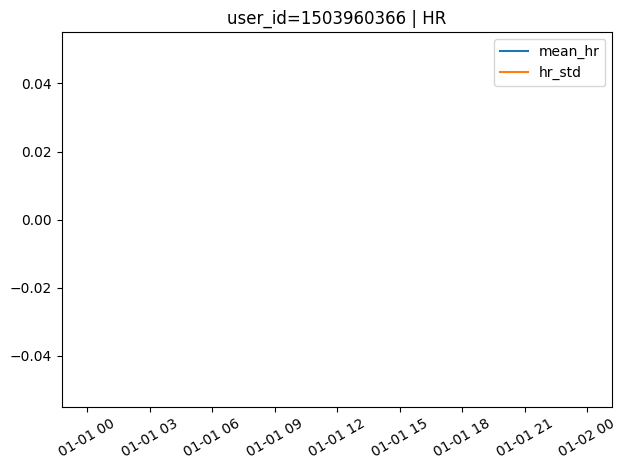

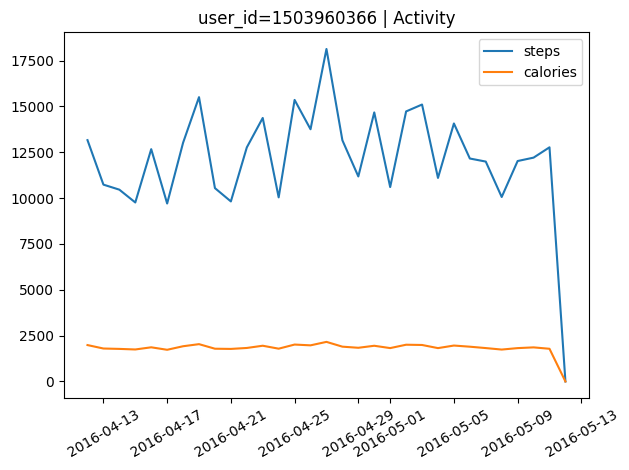

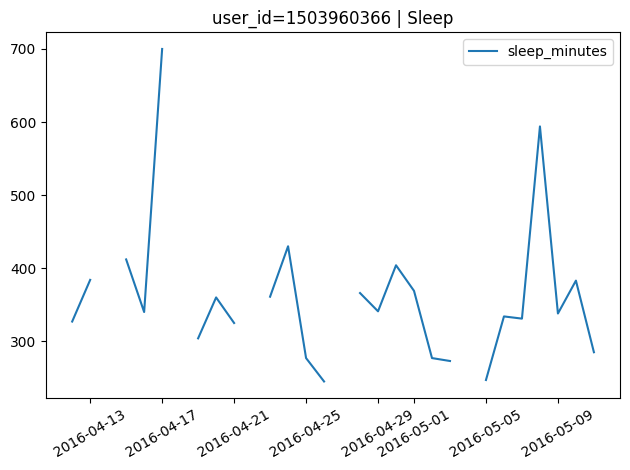

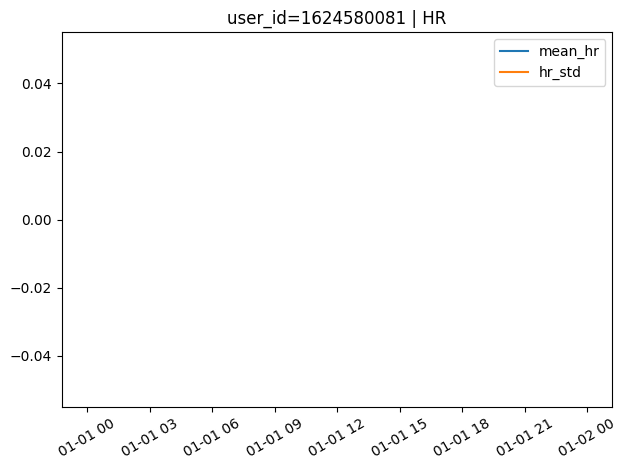

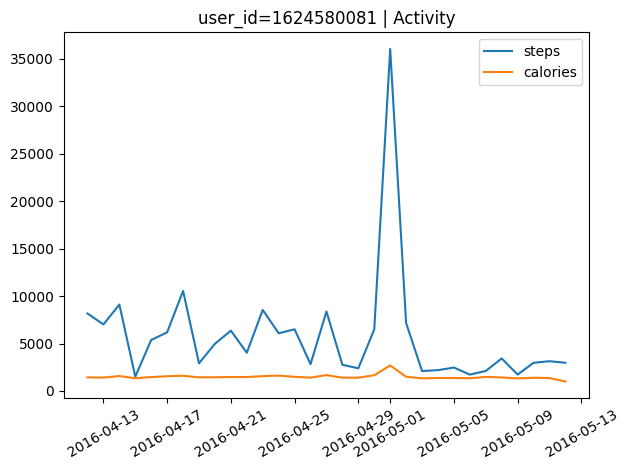

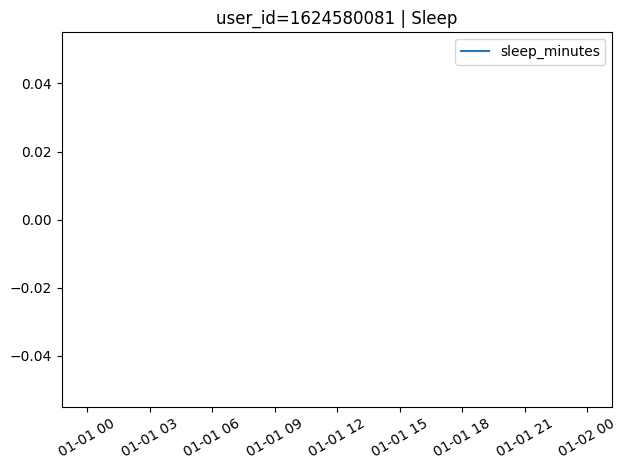

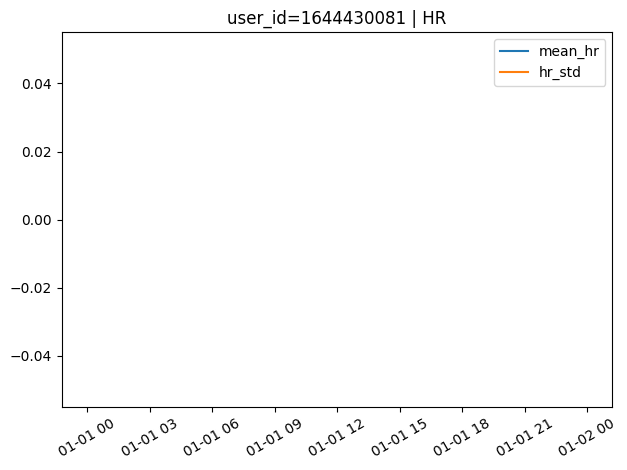

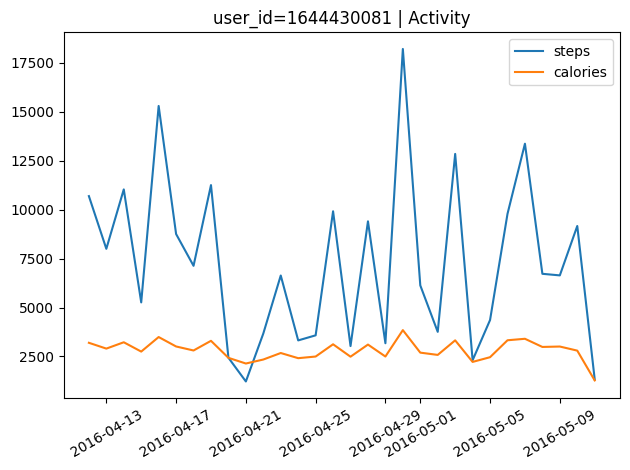

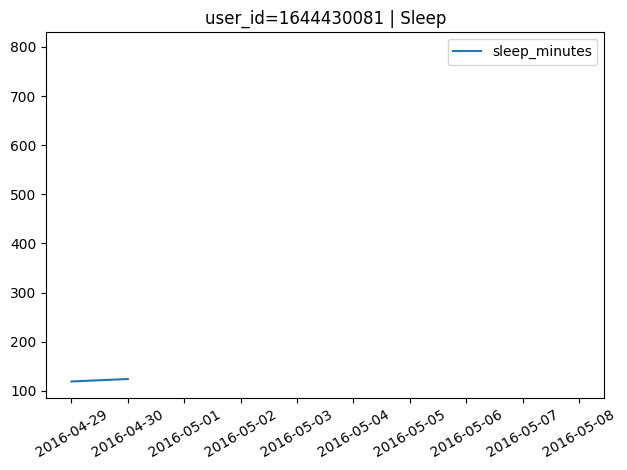

In [9]:
sample_users = df["user_id"].drop_duplicates().head(3).tolist()

for uid in sample_users:
    d = df[df["user_id"] == uid]

    fig, ax = plt.subplots()
    ax.plot(d["date"], d["mean_hr"], label="mean_hr")
    ax.plot(d["date"], d["hr_std"], label="hr_std")
    ax.set_title(f"user_id={uid} | HR")
    ax.legend()
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(d["date"], d["steps"], label="steps")
    ax.plot(d["date"], d["calories"], label="calories")
    ax.set_title(f"user_id={uid} | Activity")
    ax.legend()
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(d["date"], d["sleep_minutes"], label="sleep_minutes")
    ax.set_title(f"user_id={uid} | Sleep")
    ax.legend()
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

상태 변수 정의

In [14]:
state_cols = ["mean_hr", "hr_std", "steps", "sleep_minutes"]

사용자 기준 z-score

In [15]:
def zscore_per_user(g, cols):
    out = g.copy()
    for c in cols:
        mu = out[c].mean()
        sd = out[c].std()
        if pd.isna(sd) or sd == 0:
            out[c + "_z"] = 0.0
        else:
            out[c + "_z"] = (out[c] - mu) / sd
    return out

dfz = (
    df
    .groupby("user_id", group_keys=False)
    .apply(zscore_per_user, cols=state_cols)
)

# 방향성 반영
dfz["steps_z"] = -dfz["steps_z"]
dfz["sleep_minutes_z"] = -dfz["sleep_minutes_z"]

dfz.head()

/var/folders/sc/_dk299z14xs6j6n9ggl_ny5r0000gn/T/ipykernel_72496/3645566127.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(zscore_per_user, cols=state_cols)


,user_id,date,steps,calories,mean_hr,hr_std,sleep_minutes,mean_hr_z,hr_std_z,steps_z,sleep_minutes_z
0,1503960366,2016-04-12,13162,1985,NaN,NaN,327.0,0.0,0.0,-0.342429,0.331220
1,1503960366,2016-04-13,10735,1797,NaN,NaN,384.0,0.0,0.0,0.452661,-0.236074
2,1503960366,2016-04-14,10460,1776,NaN,NaN,NaN,0.0,0.0,0.542752,NaN
3,1503960366,2016-04-15,9762,1745,NaN,NaN,412.0,0.0,0.0,0.771418,-0.514745
4,1503960366,2016-04-16,12669,1863,NaN,NaN,340.0,0.0,0.0,-0.180921,0.201837


상태 LEVEL 계산

In [16]:
dfz["health_state_level"] = (
    dfz["mean_hr_z"] +
    dfz["hr_std_z"] +
    dfz["steps_z"] +
    dfz["sleep_minutes_z"]
) / 4.0

dfz[["user_id", "date", "health_state_level"]].head()

,user_id,date,health_state_level
0,1503960366,2016-04-12,-0.002802
1,1503960366,2016-04-13,0.054147
2,1503960366,2016-04-14,NaN
3,1503960366,2016-04-15,0.064168
4,1503960366,2016-04-16,0.005229


 상태 SPEED 계산

In [17]:
WINDOW = 7

def rolling_slope(values):
    n = len(values)
    if n < 2:
        return 0.0
    x = np.arange(n)
    y = values
    x_mean = x.mean()
    y_mean = y.mean()
    denom = ((x - x_mean) ** 2).sum()
    if denom == 0:
        return 0.0
    return ((x - x_mean) * (y - y_mean)).sum() / denom


def add_speed(g):
    g = g.sort_values("date").copy()
    lv = g["health_state_level"].values
    speed = np.zeros(len(g))

    for i in range(len(g)):
        start = max(0, i - WINDOW + 1)
        speed[i] = rolling_slope(lv[start:i+1])

    g["health_state_speed"] = speed
    return g


dfz = (
    dfz
    .groupby("user_id", group_keys=False)
    .apply(add_speed)
)

dfz[["user_id", "date", "health_state_speed"]].head()

/var/folders/sc/_dk299z14xs6j6n9ggl_ny5r0000gn/T/ipykernel_72496/1031328546.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(add_speed)


,user_id,date,health_state_speed
0,1503960366,2016-04-12,0.000000
1,1503960366,2016-04-13,0.056949
2,1503960366,2016-04-14,NaN
3,1503960366,2016-04-15,NaN
4,1503960366,2016-04-16,NaN


최종 health_state_index

In [18]:
dfz["health_state_index"] = (
    dfz["health_state_level"] +
    dfz["health_state_speed"] * WINDOW
)

dfz[[
    "user_id",
    "date",
    "health_state_level",
    "health_state_speed",
    "health_state_index"
]].head()

,user_id,date,health_state_level,health_state_speed,health_state_index
0,1503960366,2016-04-12,-0.002802,0.000000,-0.002802
1,1503960366,2016-04-13,0.054147,0.056949,0.452790
2,1503960366,2016-04-14,NaN,NaN,NaN
3,1503960366,2016-04-15,0.064168,NaN,NaN
4,1503960366,2016-04-16,0.005229,NaN,NaN


In [19]:
out_cols = [
    "user_id", "date",
    "mean_hr", "hr_std", "steps", "calories", "sleep_minutes",
    "health_state_level",
    "health_state_speed",
    "health_state_index"
]

dfz[out_cols].to_csv(
    "../data_csv/health_timeseries_core_state.csv",
    index=False
)

print("Saved: ../data_csv/health_timeseries_core_state.csv")

Saved: ../data_csv/health_timeseries_core_state.csv


① 상태가 ‘사건이 아님’을 데이터로 한 번 더 확인

In [20]:
for uid in sample_users:
    d = dfz[dfz["user_id"] == uid]
    print(uid, d["health_state_index"].describe())

1503960366 count    3.000000
mean     0.174947
std      0.243732
min     -0.002802
25%      0.036025
50%      0.074852
75%      0.263821
max      0.452790
Name: health_state_index, dtype: float64
1624580081 count    31.000000
mean      0.068709
std       0.557075
min      -2.134771
25%      -0.094709
50%       0.086486
75%       0.203587
max       1.282880
Name: health_state_index, dtype: float64
1644430081 count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: health_state_index, dtype: float64


level vs speed 분리가 의미 있는지 한 번만 확인  (= SOH 대응 논리 고정)